In [1]:
import csv
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


from matplotlib import cm
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Let's just create a visualization function for easier life! :D
def show_graph(n, x, y, centers):
    colors = cm.coolwarm(np.array(labels).astype(float) / n)
    fig = plt.figure(figsize=(18, 18))
    plt.scatter(x, y, c=colors, s=50, alpha=0.5)
    plt.scatter(centers[:,0], centers[:,1], marker='o', c='white', s=500, edgecolor='k')
    for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$'%i, s=300, edgecolor='k')
    plt.show()
    
def show_graph_3d(n, x, y, z, centers):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(40, 40))
    colors = cm.coolwarm(np.array(labels).astype(float) / n)

    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c=colors)

    ax.scatter(centers[:,0], centers[:,1], centers[:,2], marker='o', c='white', s=2000, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter(c[0], c[1], c[2], marker='$%d$'%i, s=300, edgecolor='k')
    plt.show()
    
def show_variance_graph(variance):
    fig, ax = plt.subplots(figsize=(20, 20))
    
    for i, v in enumerate(variance):
        ax.plot([i + 1, i + 1], [0, v], '-', color='red')
    
    ax.set_xlabel('PC')
    ax.set_ylabel('Exp. variance')
#     ax.set_ylim([0, 1])

    ax2 = ax.twinx()
#     ax2.set_ylim([0, 1])
    sum_var = np.cumsum(variance)
    ax2.plot(range(len(sum_var) + 1), [0] + list(sum_var), '-', color='black')

    plt.show()

In [3]:
FILE_NAME = '../data/dataset_diabetes/diabetic_data.csv'

# We need to clean the data first! :D
le = preprocessing.LabelEncoder()
raw_df = pd.read_csv(FILE_NAME, index_col='encounter_id', na_values="?", low_memory=False)

# df = raw_df.apply(le.fit_transform)

pd.set_option('max_columns',50)
raw_df.head(5)

patient_nbr             race  gender      age weight  \
encounter_id                                                         
2278392           8222157        Caucasian  Female   [0-10)    NaN   
149190           55629189        Caucasian  Female  [10-20)    NaN   
64410            86047875  AfricanAmerican  Female  [20-30)    NaN   
500364           82442376        Caucasian    Male  [30-40)    NaN   
16680            42519267        Caucasian    Male  [40-50)    NaN   

              admission_type_id  discharge_disposition_id  \
encounter_id                                                
2278392                       6                        25   
149190                        1                         1   
64410                         1                         1   
500364                        1                         1   
16680                         1                         1   

              admission_source_id  time_in_hospital payer_code  \
encounter_id                                                     
2278392                         1                 1        NaN   
149190                          7                 3        NaN   
64410                           7                 2        NaN   
500364                          7                 2        NaN   
16680                           7                 1        NaN   

                     medical_specialty  num_lab_procedures  num_procedures  \
encounter_id                                                                 
2278392       Pediatrics-Endocrinology                  41               0   
149190                             NaN                  59               0   
64410                              NaN                  11               5   
500364                             NaN                  44               1   
16680                              NaN                  51               0   

              num_medications  number_outpatient  number_emergency  \
encounter_id                                                         
2278392                     1                  0                 0   
149190                     18                  0                 0   
64410                      13                  2                 0   
500364                     16                  0                 0   
16680                       8                  0                 0   

              number_inpatient  diag_1  diag_2 diag_3  number_diagnoses  \
encounter_id                                                              
2278392                      0  250.83     NaN    NaN                 1   
149190                       0     276  250.01    255                 9   
64410                        1     648     250    V27                 6   
500364                       0       8  250.43    403                 7   
16680                        0     197     157    250                 5   

             max_glu_serum A1Cresult metformin repaglinide nateglinide  \
encounter_id                                                             
2278392               None      None        No          No          No   
149190                None      None        No          No          No   
64410                 None      None        No          No          No   
500364                None      None        No          No          No   
16680                 None      None        No          No          No   

             chlorpropamide glimepiride acetohexamide glipizide glyburide  \
encounter_id                                                                
2278392                  No          No            No        No        No   
149190                   No          No            No        No        No   
64410                    No          No            No    Steady        No   
500364                   No          No            No        No        No   
16680                    No          No            No    Steady        No   

         

In [4]:
# Checking for null entries in the dataset
null_df = raw_df.copy()
nulls = null_df.apply(pd.Series.isnull).apply(lambda x: 100 * round(len(x[x==True])/len(x), 4))
nulls[nulls != 0]

race                  2.23
weight               96.86
payer_code           39.56
medical_specialty    49.08
diag_1                0.02
diag_2                0.35
diag_3                1.40
dtype: float64

# Cleaning part

I think a lot of people doesn't want to share their weight information even though its a big factor in determining diabetes. LOL

<img src="https://memegenerator.net/img/instances/84101603/y-u-no-share-weight-data.jpg" width="400">

Also, `payer_code` seems to be not needed? Maybe we can remove other columns as well.

In [5]:
list(raw_df)

['patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

### Removing un needed columns

Looking at the columns, we can probably use `patient_nbr` as the main identifier instead of using `encounter_id`.

Also as seen in above, we can probably remove `weight` and `payer_code` since there are just too many Null values.

In [6]:
le = preprocessing.LabelEncoder()
formatted_df = raw_df.copy()
# Drop
formatted_df.drop(['weight', 'payer_code'], axis=1, inplace=True)
# Get the average of date range for age (0-10) = 5
formatted_df.age = (le.fit_transform(formatted_df.age)* 10) + 5

formatted_df.dtypes

patient_nbr                  int64
race                        object
gender                      object
age                          int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide           

In [7]:
# We need to clean the datatypes of each feature. Object data types are not standardize 
# and they should be converted into proper types.
# Just check the columns for "num" or "number" keywork Lol
categorical_cols = [
    'patient_nbr', 'race', 'gender', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id',
    'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
    'metformin', 'repaglinide', 'nateglinide', 
    'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'insulin',
    'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed', 
    'max_glu_serum', 'A1Cresult', 'readmitted'
]

numerical_cols = [
    'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]
formatted_df = formatted_df.fillna('')

for item in categorical_cols:
    formatted_df[item] = formatted_df[item].astype('category')

for item in numerical_cols:
    formatted_df[item] = formatted_df[item].astype('int')
    
formatted_df[['patient_nbr']].describe(exclude=None)
# formatted_df.dtypes

patient_nbr
count        101766
unique        71518
top        88785891
freq             40

#### Unique patients

It seems that there are duplicate entries for patient. Let's try to create a new data frame with unique entries of patient.

<img src="https://i.kym-cdn.com/entries/icons/original/000/023/397/C-658VsXoAo3ovC.jpg" width="400">

Making patients unique will make sure that no comparison are made between the same patients. We'll probably choose the first entry that matches a `patient_nbr`


In [8]:
unique_patient_df = formatted_df.copy()
unique_patient_df = formatted_df.drop_duplicates(subset=['patient_nbr'])
unique_patient_df.index = unique_patient_df['patient_nbr']
unique_patient_df.drop('patient_nbr', axis=1, inplace=True)
unique_patient_df.head(5)


/Users/ninz/.local/share/virtualenvs/cs297-fZk1rqQo/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


race  gender  age admission_type_id  \
patient_nbr                                                   
8222157            Caucasian  Female    5                 6   
55629189           Caucasian  Female   15                 1   
86047875     AfricanAmerican  Female   25                 1   
82442376           Caucasian    Male   35                 1   
42519267           Caucasian    Male   45                 1   

            discharge_disposition_id admission_source_id  time_in_hospital  \
patient_nbr                                                                  
8222157                           25                   1                 1   
55629189                           1                   7                 3   
86047875                           1                   7                 2   
82442376                           1                   7                 2   
42519267                           1                   7                 1   

                    medical_specialty  num_lab_procedures  num_procedures  \
patient_nbr                                                                 
8222157      Pediatrics-Endocrinology                  41               0   
55629189                                               59               0   
86047875                                               11               5   
82442376                                               44               1   
42519267                                               51               0   

             num_medications  number_outpatient  number_emergency  \
patient_nbr                                                         
8222157                    1                  0                 0   
55629189                  18                  0                 0   
86047875                  13                  2                 0   
82442376                  16                  0                 0   
42519267                   8                  0                 0   

             number_inpatient  diag_1  diag_2 diag_3  number_diagnoses  \
patient_nbr                                                              
8222157                     0  250.83                                1   
55629189                    0     276  250.01    255                 9   
86047875                    1     648     250    V27                 6   
82442376                    0       8  250.43    403                 7   
42519267                    0     197     157    250                 5   

            max_glu_serum A1Cresult metformin repaglinide nateglinide  \
patient_nbr                                                             
8222157              None      None        No          No          No   
55629189             None      None        No          No          No   
86047875             None      None        No          No          No   
82442376             None      None        No          No          No   
42519267             None      None        No          No          No   

            chlorpropamide glimepiride acetohexamide glipizide glyburide  \
patient_nbr                                                                
8222157                 No          No            No        No        No   
55629189                No          No            No        No        No   
86047875                No          No            No    Steady        No   
82442376                No          No            No        No        No   
42519267                No          No            No    Steady        No   

            tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
patient_nbr                                                            
8222157              No           No            No       No       No   
55629189             No           No            No       No       No   
86047875             No           No            No       No       No   
82442376             No           No            No       No       No   
42519267       

Now the data seems to be reasonable enough to process. (Actually we can perform even more preprocessing, but lets keep it simple for now)

<img src="https://memegenerator.net/img/instances/84101738/raw-unprocessed-data-cleaned-data-that-suits-our-needs.jpg" width="400" />

# Grouping the data

Let's try grouping the data first. Maybe something might make sense if we try to group the data.

For this part, we can use KMeans (unsupervised learning). We can also use GMMs or other clustering approach.


### Choosing our K!???

Let's perform silhouette score!

Lol, I've run this before hand in a more powerful PC :P
```
For k=3, the score is 0.43608144537313465
For k=4, the score is 0.44022638878527914
For k=5, the score is 0.4379464743506894
For k=6, the score is 0.43489337793034033
For k=7, the score is 0.4112913237706559
For k=8, the score is 0.41248333877718335
For k=9, the score is 0.3991669291008952
For k=10, the score is 0.3860249631169659
For k=11, the score is 0.3790975646646471
For k=12, the score is 0.37254284126252263
For k=13, the score is 0.37216367433388714
For k=14, the score is 0.3782694996603581
For k=15, the score is 0.38041127260635493
For k=16, the score is 0.3739997603413672
For k=17, the score is 0.37654359778374713
For k=18, the score is 0.3722767228427836
```

**k = 4 it is!**

<img src="https://memegenerator.net/img/instances/84101866/the-number-of-cores-i-used-to-run-this-is-over-9000.jpg" width="400" />

In [9]:
# Let's try out 4 clusters??
CLUSTERS = 4

le2 = preprocessing.LabelEncoder()

df_0 = unique_patient_df.copy()
df_0 = df_0.apply(le2.fit_transform)


In [10]:
km0 = KMeans(n_clusters=CLUSTERS, n_init=50, tol=1e-10, random_state=1234).fit(df_0)
labels = km0.predict(df_0)

In [11]:
df_0['Label'] = labels
# How many are there in a cluster?
df_0.groupby(['Label']).size()

Label
0    31107
1    15688
2    11818
3    12905
dtype: int64

# ARRGGHHHH HOW DO I GRAPH THIS DATA????? T___T 

If only I can choose which columns affected the result the most and graph the label based on them T_T

<img src="https://memegenerator.net/img/instances/84101929/one-does-not-simply-compare-data.jpg" width="400" />

**OH WAIT, I CAN!!!! HAHAHA**

We can see which features have varying means and we can use this features to graph our clusters! Using atleast 3 features should give us a good result (AND WE CAN'T GRAPH BEYOND 3)

In [12]:
clm = list(df_0)
print(df_0[clm].groupby(['Label']).mean())

           race    gender       age  admission_type_id  \
Label                                                    
0      2.599126  0.494519  6.120905           1.077217   
1      2.614737  0.435747  6.013386           1.171341   
2      2.604925  0.446691  6.051447           1.092571   
3      2.607981  0.464781  6.006432           1.076404   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
Label                                                                    
0                      2.464944             4.547980          3.365513   
1                      2.595869             4.395971          2.819352   
2                      2.519546             4.296412          3.427568   
3                      2.760713             4.355986          3.549322   

       medical_specialty  num_lab_procedures  num_procedures  num_medications  \
Label                                                                           
0              11.144115           43.246150

**HMMMM Not very helpful lol, I thought by looking at the mean for each feature, I can see which features are relevant based on their values**

We can still try anyway??? Lets pick `diag_1` and `diag_2`, `diag_3`. This has the highest variance among all means.

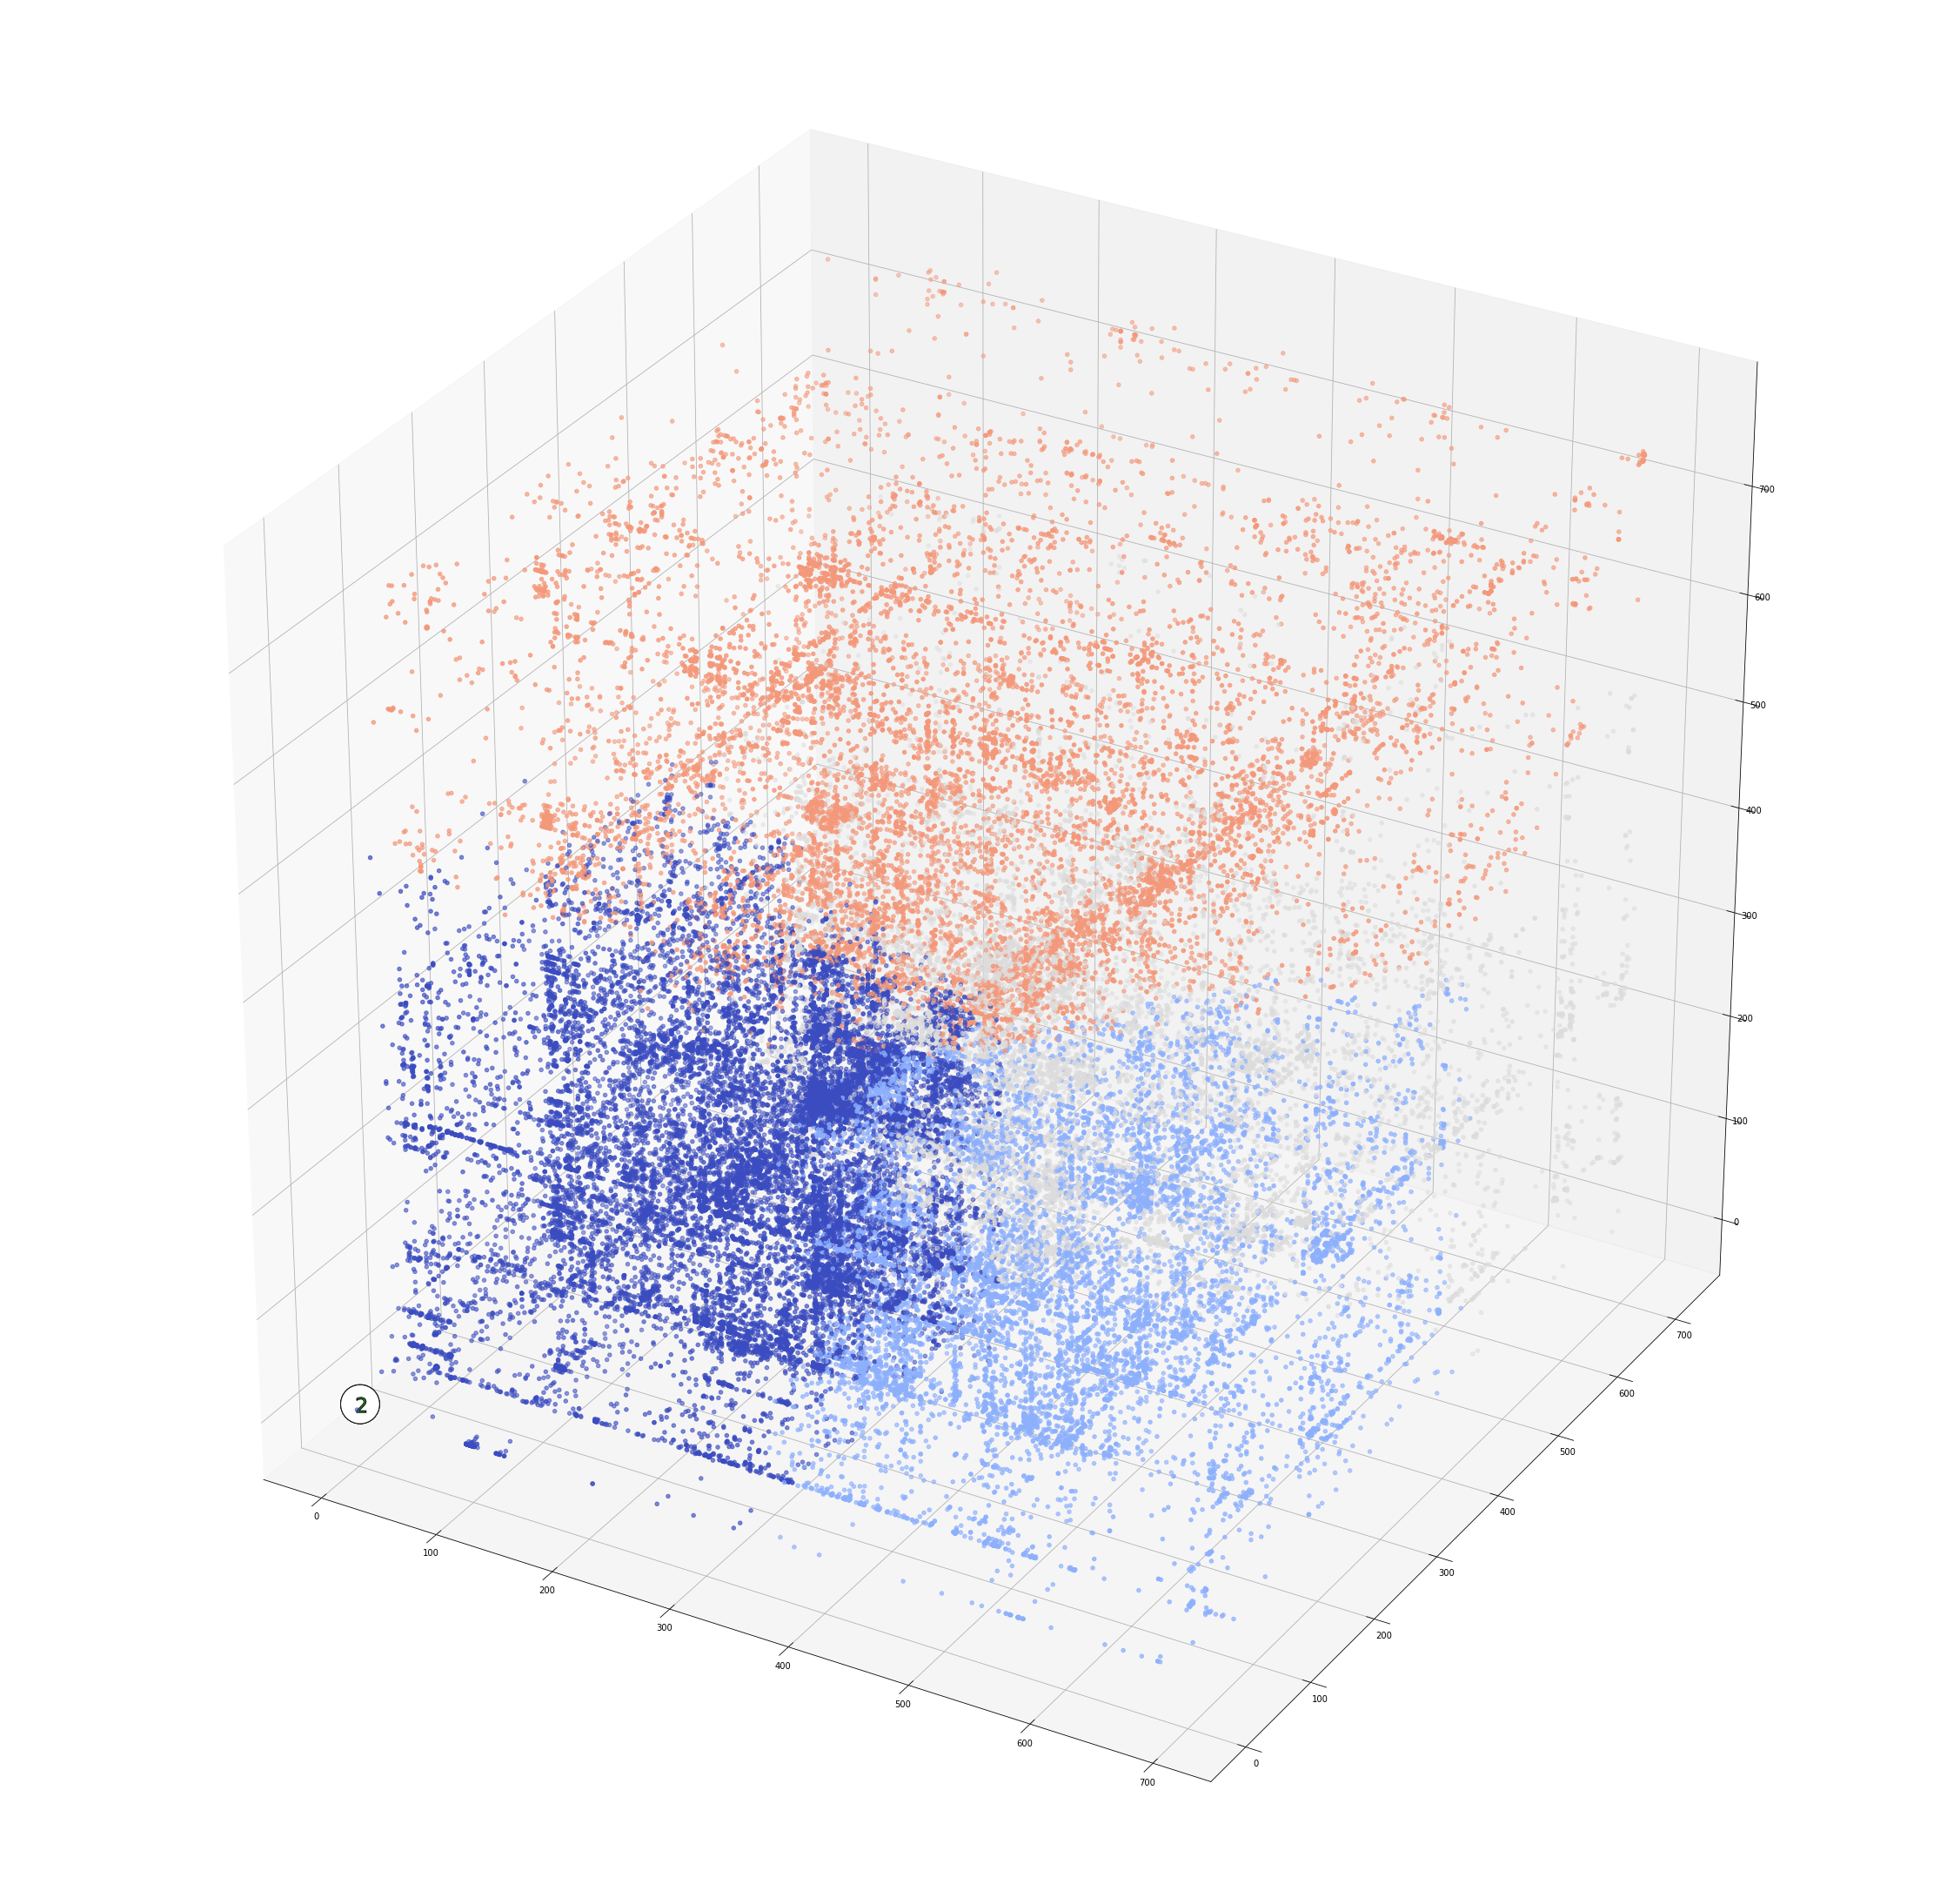

In [13]:
centers = km0.cluster_centers_
show_graph_3d(CLUSTERS, df_0['diag_1'], df_0['diag_2'], df_0['diag_3'], centers)
# LOL looks like some rubics cube

### Now just to be sure, lets use PCA :D

We cannot rely on human eyes alone. So, lets reduce the features using PCA, then let's see how the clusters will turn out.

In [14]:
pca_df = unique_patient_df.copy()
pca_df = pca_df.apply(le2.fit_transform)

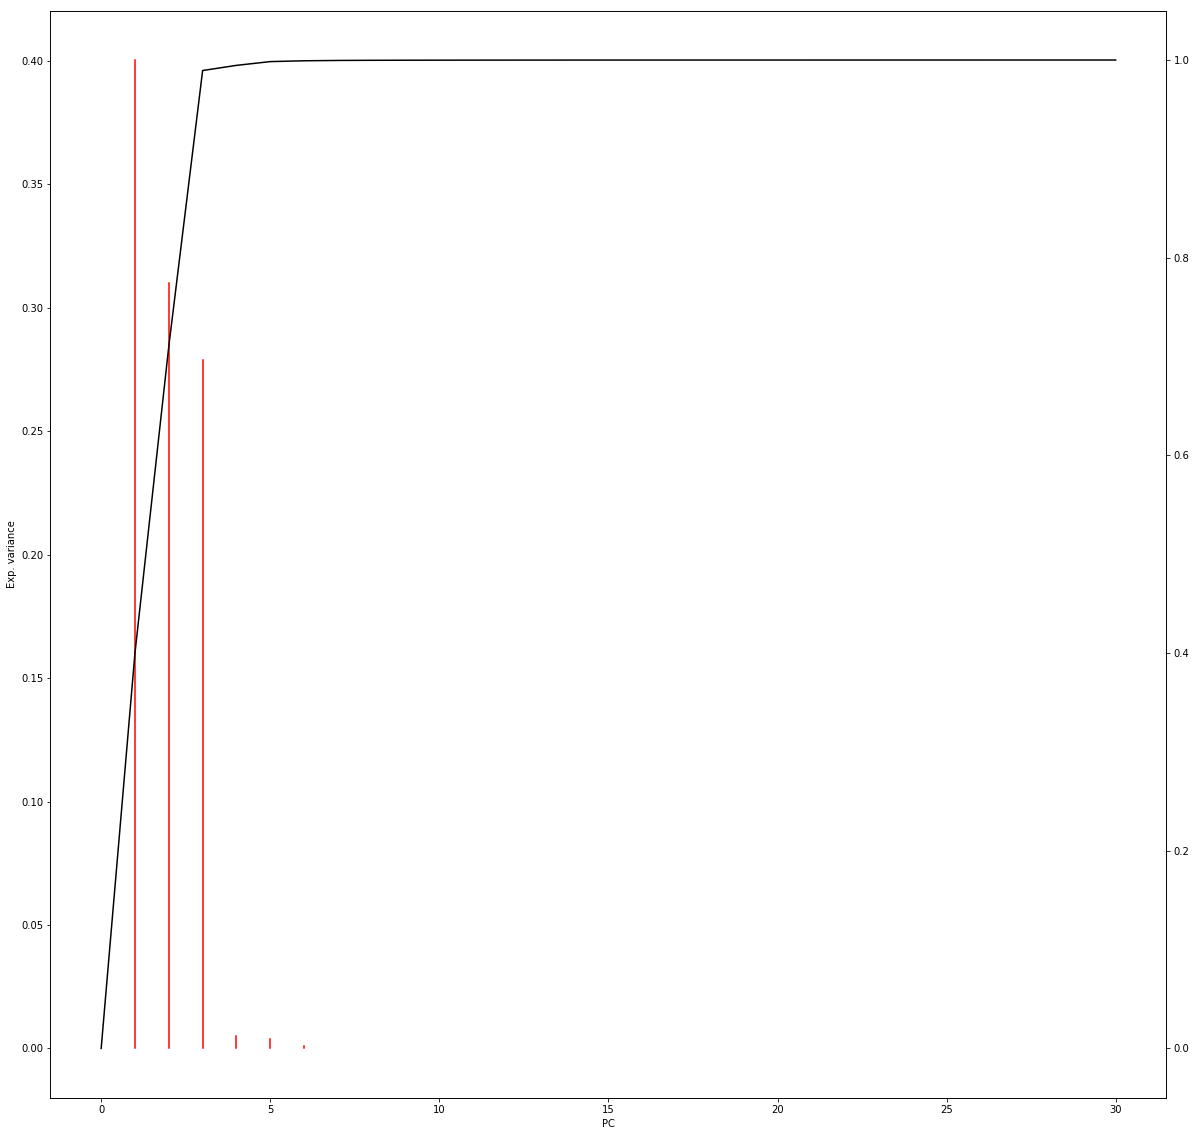

In [15]:
pca_analysis = PCA(n_components=30).fit(pca_df)
variance_analysis = pca_analysis.explained_variance_ratio_
pca_df_new = pca_analysis.transform(pca_df)
show_variance_graph(variance_analysis)
# variance_analysis

Yeah now we can see that only three PCs contribute to most of the variance.
We just used 30 features to begin with but you can already see that the other PCs are already invisibbblleee :(

In [16]:
df_1 = unique_patient_df.copy()
df_1 = df_1.apply(le2.fit_transform)

In [17]:
# Lets try 3 components for PCA
pca = PCA(n_components=3).fit(df_1)
variance = pca.explained_variance_ratio_
df_1_x_new = pca.transform(df_1)
_sum = round(sum(variance) * 100, 2)
print(f'Total feature representation: {_sum}')

Total feature representation: 98.94


In [18]:
km1 = KMeans(n_clusters=CLUSTERS, n_init=50, tol=1e-10, random_state=1234).fit(df_1_x_new)
labels2 = km1.predict(df_1_x_new)

In [19]:
# Create new data frame for labels
h = ['l1', 'l2', 'l3']
df_1_PCA_updated = pd.DataFrame(df_1_x_new, columns=h)

In [20]:
df_1_PCA_updated['Labels'] = labels2

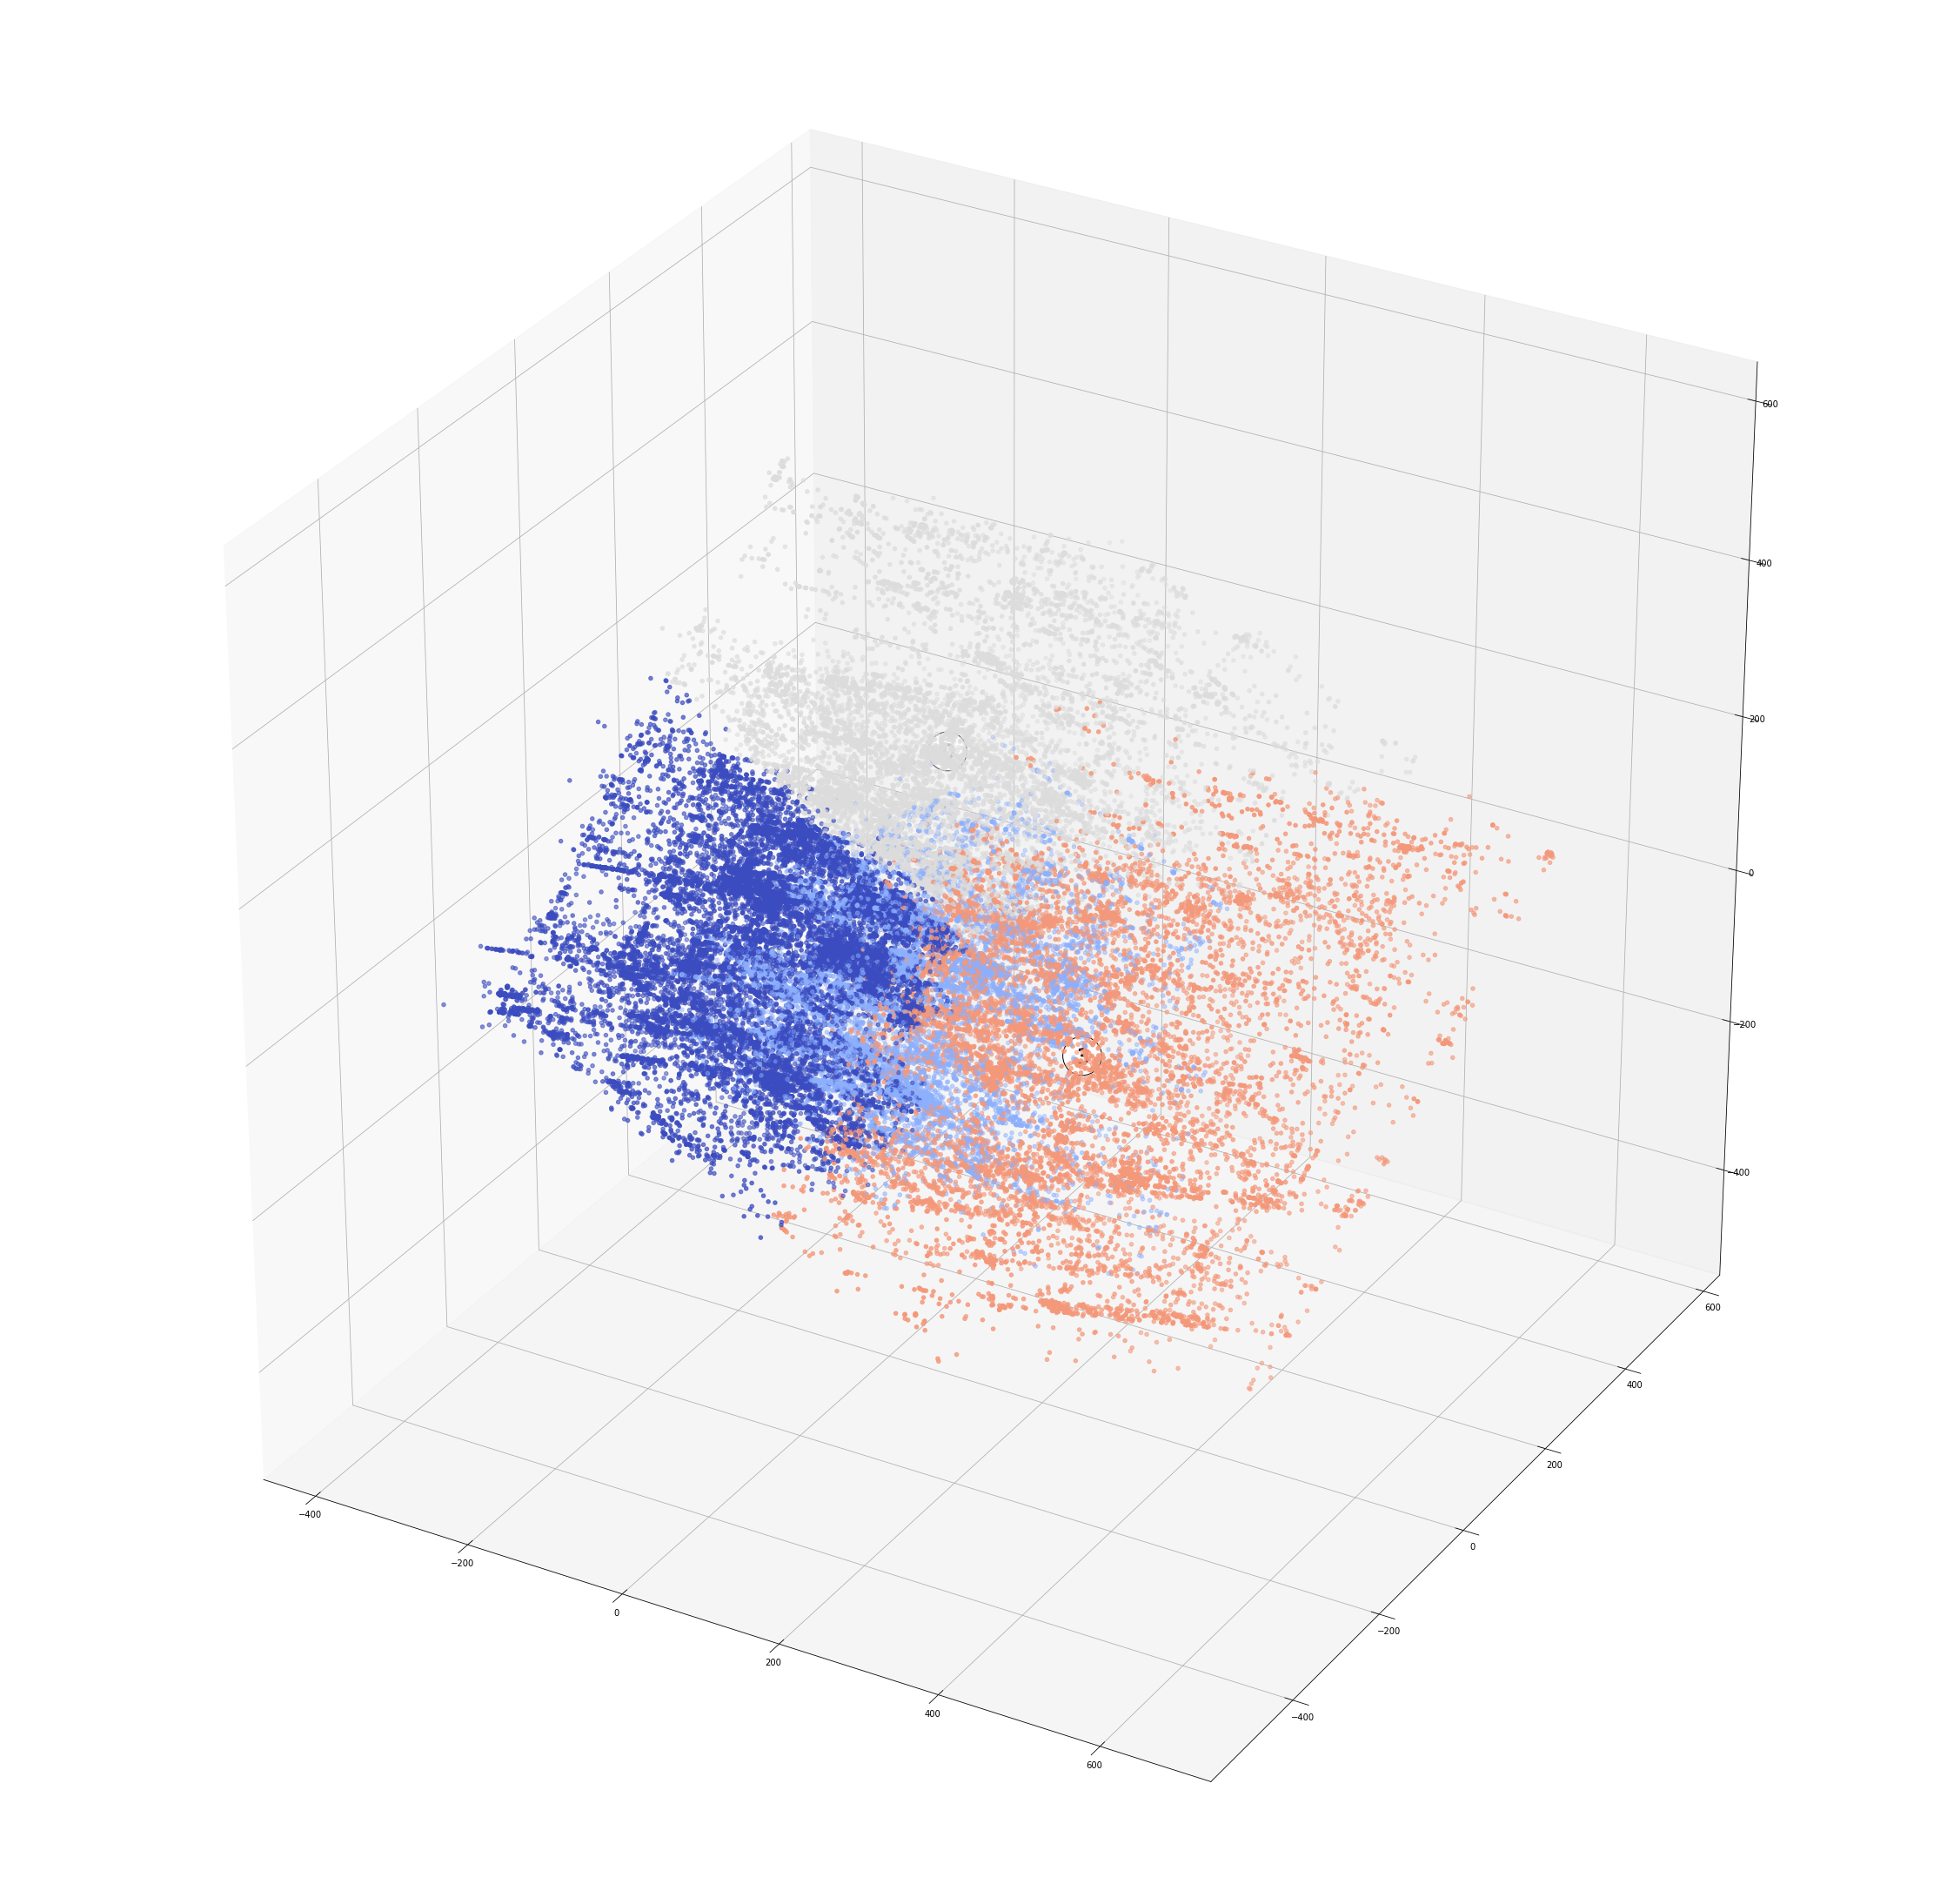

In [21]:
centers = km1.cluster_centers_
show_graph_3d(CLUSTERS, df_1_PCA_updated['l1'], df_1_PCA_updated['l2'], df_1_PCA_updated['l3'], centers)

In [22]:
# How many are there in a cluster?
df_1_PCA_updated.groupby(['Labels']).size()

Labels
0    11818
1    15688
2    31108
3    12904
dtype: int64

In [23]:
centers

array([[   3.87596418,  130.66783426,  193.11984673],
       [ -51.00245775,  130.12477147, -142.72897909],
       [ -95.33369943,  -86.41168193,    7.52557779],
       [ 288.27969114,  -69.5548108 ,  -21.48665519]])

**Hmmm, seems familiar**

Its like the first graph, just on a different plane. This probably means that the dominant feature, even if we use PCA, is `diag_1`, `diag_2` and `diag_3`. So we can probably say that depending on the diagnosis, we can group diabetes patients.

## Final thoughts

- We can do better with choosing the data for duplicate patients. Right now we are choosing the first instance but there might be some other metrics we can perform to choose which duplicates to drop
- We can try to use other classification methods!
- The data might be more useful for supervised learning since there are other features that might be more useful for supervised learning


## Some stuff from scratch notebook

In [24]:
# PCA with 2 features
df_2 = unique_patient_df.copy()
df_2 = df_2.apply(le2.fit_transform)

In [25]:
pca = PCA(n_components=2).fit(df_2)
df_2_x_new = pca.transform(df_2)

In [26]:
km2 = KMeans(n_clusters=CLUSTERS, n_init=50, tol=1e-10, random_state=1234).fit(df_2_x_new)
labels3 = km2.predict(df_2_x_new)

In [27]:
# Create new data frame for labels
h2 = ['l1', 'l2']
df_2_PCA_updated = pd.DataFrame(df_2_x_new, columns=h2)

In [28]:
df_2_PCA_updated['Labels'] = labels3

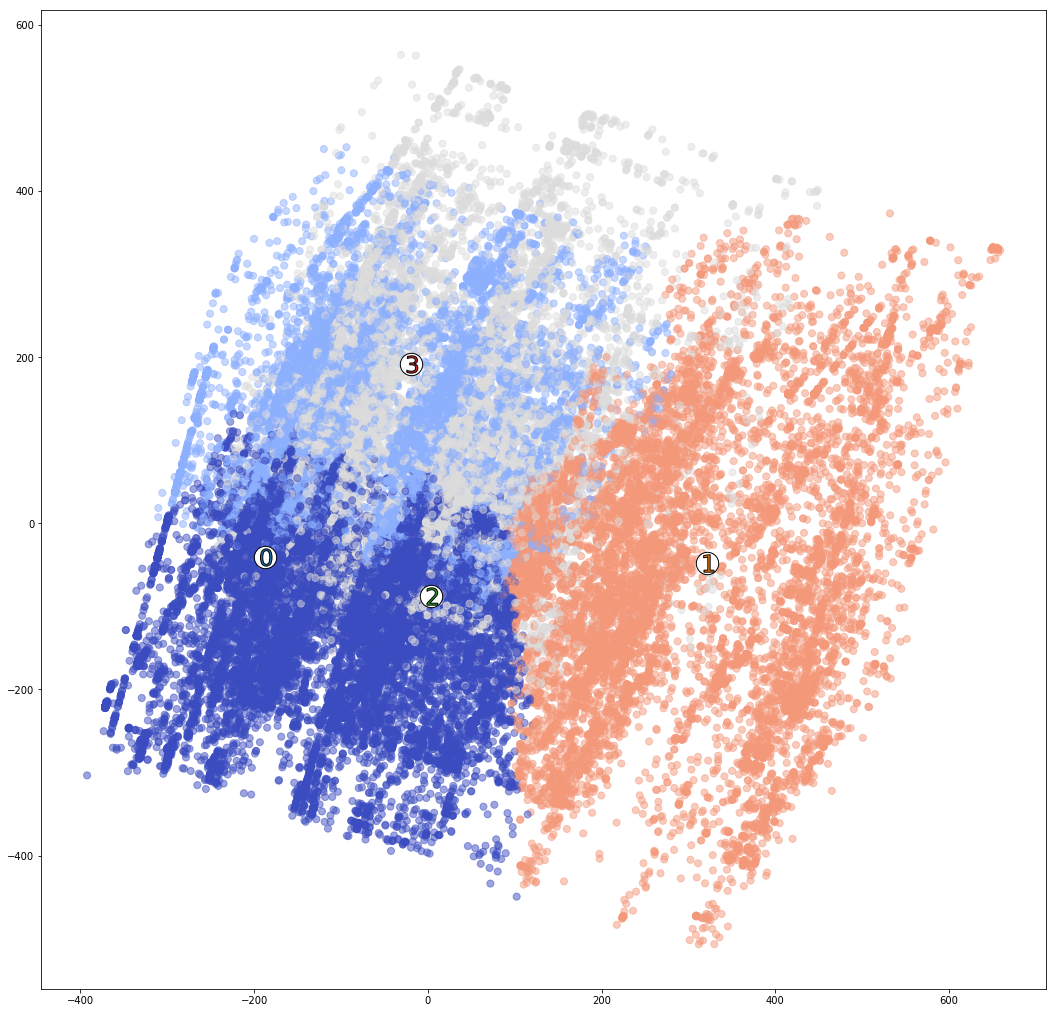

In [29]:
centers = km2.cluster_centers_
show_graph(CLUSTERS, df_2_PCA_updated['l1'], df_2_PCA_updated['l2'], centers)